In [277]:
%matplotlib inline
import re
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sbn
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

In [278]:
sum_of_courses = requests.get('https://www.luther.edu/catalog/curriculum')

In [279]:
soup = BeautifulSoup(sum_of_courses.text, 'html.parser')

In [280]:
department_list = soup.select('ul.childrenList a')
major_list = []
for item in department_list:
    department = item.get('href', 'None')
    if department != 'None':
        major_list.append(department)

In [285]:
data_frame = pd.DataFrame(columns=['Department', 'CourseName', 'CourseNumber', 'Hours', 'GenEds', 'Prereqs', 'Description'])

In [286]:
websites =[]
for i in major_list:
    x = 'https://www.luther.edu/catalog/curriculum/{}'.format(i)
    websites.append(x)

In [289]:
def search_for_classes(my_soup,row):
    department = my_soup.find_all('h1', class_='pageTitle')[0].text
    courses = my_soup.find_all('div', class_='courseContainer')
    for i in courses:
        c_title = i.find_all('span', class_='courseTitle')[0].text
        c_number = i.find_all('span', class_='courseNumber')[0].text
        cr_hours = i.find_all('li')[0].text
        for part in i.find_all('li'):
            if part.find_all('i', class_='fa-li fa fa-book fa-lg') != []:
                prereks = part.text.split(' ')[1:]
                prereks = ' '.join(prereks)
            else:
                prereks = ''
        description = i.find_all('span', class_='courseDescription')[0].text
        gen_eds = []
        for i in item.find_all('span', class_='genEd'):
            gen_eds.append(i.text)
        gen_ed_string = ', '.join(gen_eds)
        data_frame.loc[row] = [department, c_title, c_number, cr_hours, gen_ed_string, prereks, description]
        row += 1
    return row

In [290]:
row = 0
for i in major_list:
    specific_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(i))
    soup = BeautifulSoup(specific_course.text, 'html.parser')
    row = search_for_classes(soup, row)

In [228]:
df.head()

Dept                                CourseName  \
0  Women and Gender Studies  Introduction to Women and Gender Studies   
1  Women and Gender Studies                     Contact Improvisation   
2  Women and Gender Studies             Literature of African Peoples   
3  Women and Gender Studies                   Biology of Race And Sex   
4  Women and Gender Studies           Sex in the Bible and the Qur'an   

  CourseNumber    Hours                                             GenEds  \
0     WGST 130  4 hours                                     Human Behavior   
1     WGST 131  4 hours           Human Behavior, Human Expression, Skills   
2     WGST 147  4 hours  Human Expression—Primary Texts, Historical, In...   
3     WGST 195  4 hours                               Natural World—Nonlab   
4     WGST 212  4 hours           Religion, Human Expression—Primary Texts   

                            Prereqs  \
0                                     
1                                     
2  PAID 111D or transfer equivalent   
3                   Junior standing   
4              REL 101, 111, or 112   

                                         Description  
0  The course combines a cross-cultural survey of...  
1  This course is an introduction to the fundamen...  
2  Modern African writers are some of the most dy...  
3  This course will introduce students to basic c...  
4  This course will explore constructions of gend...

In [307]:
new_list = []
alist = []
import re
for item in data_frame.Prereqs:
    new_list.append(re.findall(r'[A-Z][A-Z][A-Z]+', item))
for item in new_list:
    alist.append(item)
    
new_df = pd.DataFrame(columns= ['abbv', 'relations'])

new_df['abbv'] = data_frame.CourseNumber.map(lambda x : x.split(' ')[0])

new_df['relations'] = alist

In [308]:
s = new_df.relations.apply(pd.Series).stack().reset_index(level =1, drop=True)

s.name = 'relation'

new_df = new_df.drop('relations', axis=1).join(s)

new_df = new_df.reset_index(drop = True)

new_df = new_df.drop_duplicates()

new_df = new_df.reset_index(drop = True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

In [312]:
new_df

abbv relation
0    ACCTG    ACCTG
1     AFRS     PAID
2     AFRS      SOC
3     ANTH     ANTH
4      ART      ART
5      ART     EDUC
6      ART      THE
7     ARTH     ARTH
8     ARTH     WGST
9    ATHTR    ATHTR
10     BIO      BIO
11     BIO     CHEM
12     BIO     PHYS
13    CHEM     CHEM
14    CHEM      BIO
15    CHEM     MATH
16    CHEM     PHYS
17    CHEM      AND
18    CHIN     CHIN
19    CLAS     PAID
20    CLAS     CLAS
21    COMS     COMS
22    COMS     WGST
23      CS     MATH
24     DAN      DAN
25     DAN      THE
26     DAN      ART
27      DS     MATH
28    ECON     ECON
29     ENG     PAID
..     ...      ...
76      PE     EDUC
77      PE      BIO
78    PHYS     PHYS
79    PHYS     MATH
80    PSYC     PSYC
81    PSYC     MATH
82     REL      REL
83     REL     PAID
84     RUS      RUS
85     SCI     MATH
86     SCI      BIO
87     SCI     NURS
88     SCI      SCI
89    SCST     SCST
90    SCST     PAID
91      SW     POLS
92      SW      SOC
93     SOC      SOC
94     SOC     COMS
95     SOC     MATH
96    SPAN     SPAN
97     THE      THE
98    WGST     PAID
99    WGST      REL
100   WGST      SOC
101   WGST     PHIL
102   WGST     WGST
103   WGST     PSYC
104   WGST     COMS
105   WGST      ART

[106 rows x 2 columns]

In [320]:
#GRAPH WITH ONLY PRE-REQS DIRECTING TO ITS COURSE.
graf = nx.DiGraph()
graf.add_nodes_from(new_df.abbv)

for index, row in new_df.iterrows():
    graf.add_edge(row['abbv'], row['relation'])

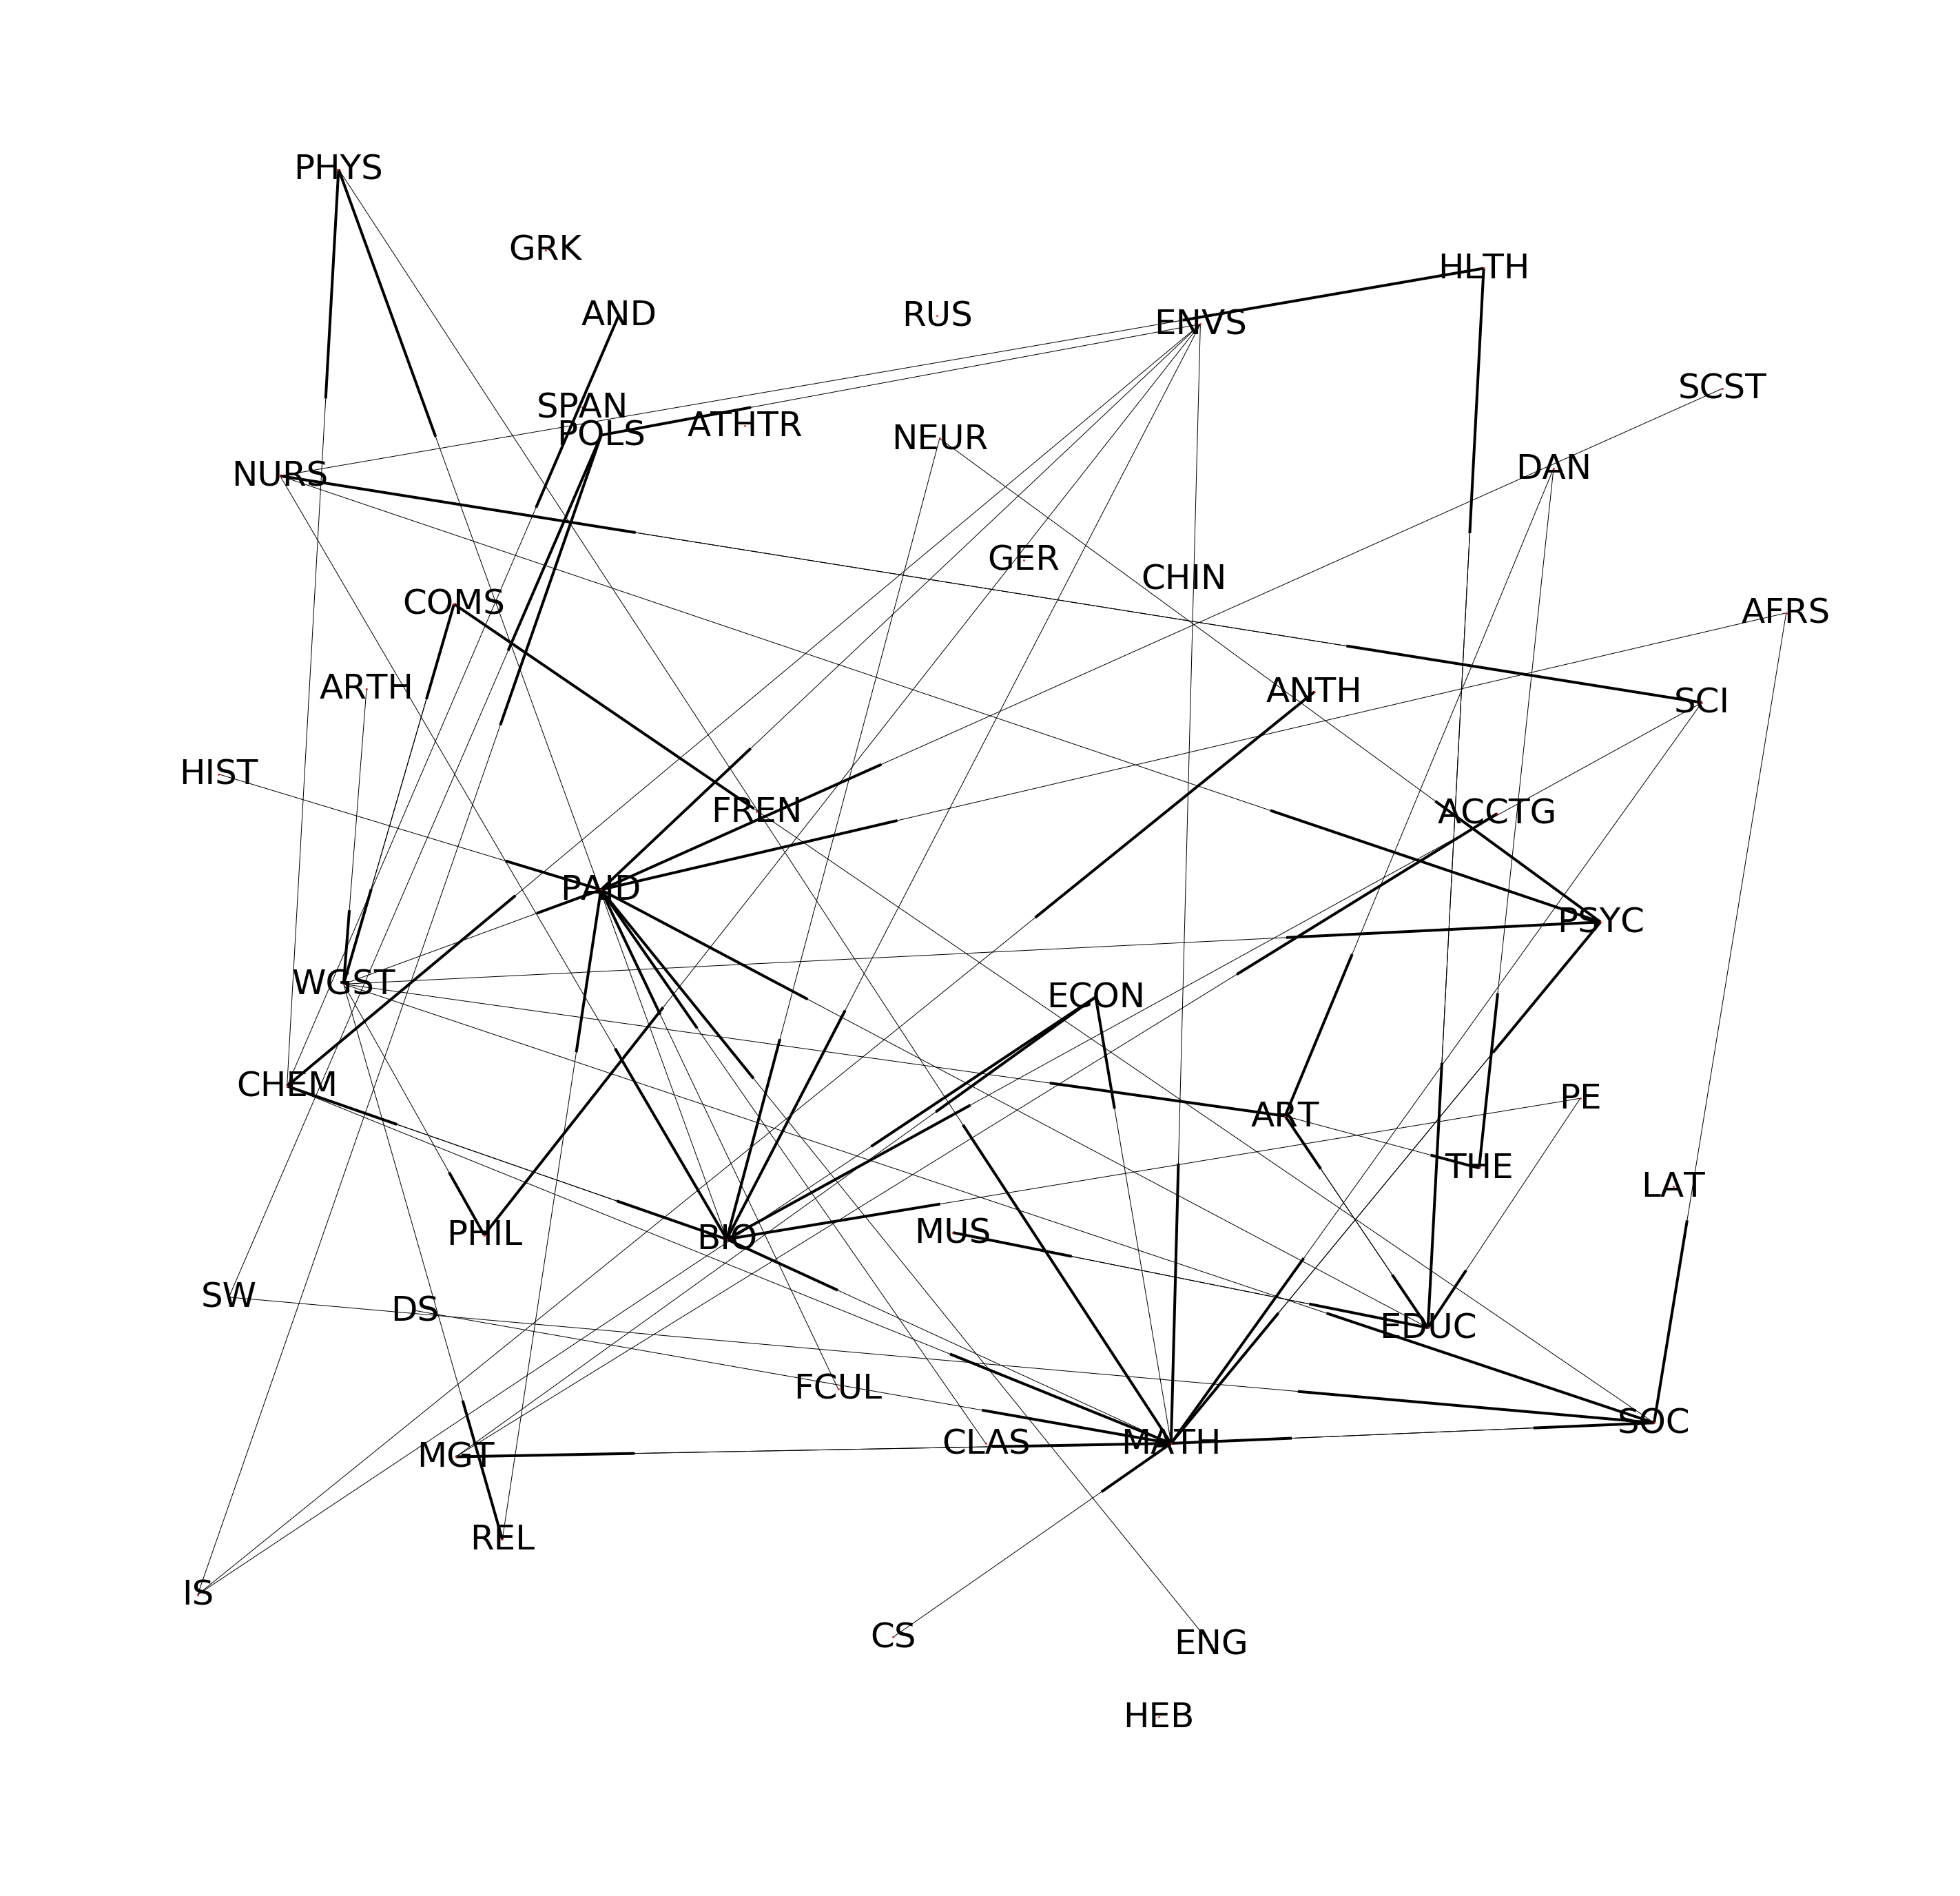

In [321]:
graffig, gax = plt.subplots(figsize = (50,50))
nx.draw(graf,nx.spring_layout(graf, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 50, node_size = 5)

In [337]:
try:
    for i in major_list:
        this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(i))
        soup = BeautifulSoup(this_course.text, 'html.parser')
        list_a = []
        if soup.find_all('h1', class_='pageTitle')[0].text != 'Nordic Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Library and Information Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Biblical Languages' and soup.find_all('h1', class_='pageTitle')[0].text != 'International Business':
            a = soup.find_all('div', class_='catalog_block')
            b = soup.find_all('span', class_='courseNumber')[0].text
        else:
            pass
        for i in a:
            i = i.text
            list_a.append(i)
        if len(b) > 1 :
            b = that.split(' ')
        b.pop()
        b = ''.join(that)
        list_b = []
        for i in list_a:
            list_b.append(re.findall(r'[A-Z][A-Z]+ [0-9]+', i))
        united = [i for sublist in list_b for i in sublist]
        lista = []
        for i in united:
            i = i.split(' ')
            lista.append(i)

        for i in lista:
            del i[1]
        lista = [i for sublist in lista for i in sublist]
        lista = set(lista)
        lista = list(lista)
        new_df.set_value(-1, 'abbv', b)
        new_df.set_value(-1, 'relation', lista)
        new_df = new_df.reset_index(drop=True)
except:
    print(i)

['ACCTG']


In [338]:
series = new_df.relation.apply(pd.Series).stack().reset_index(level = 1, drop=True)

series.name = 'relations'

new_df = new_df.drop('relation', axis=1).join(series)

new_df = new_df.drop_duplicates()

new_df = new_df.sort_values(by=['abbv'])

new_df = new_df.replace('', np.nan, regex=True)

new_df = new_df.replace('^AND', np.nan, regex=True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

ValueError: columns overlap but no suffix specified: Index(['relations'], dtype='object')

In [329]:
graf2 = nx.DiGraph()
graf2.add_nodes_from(new_df.abbv)


for index, row in new_df.iterrows():
    graf2.add_edge(row['abbv'], row['relations'])

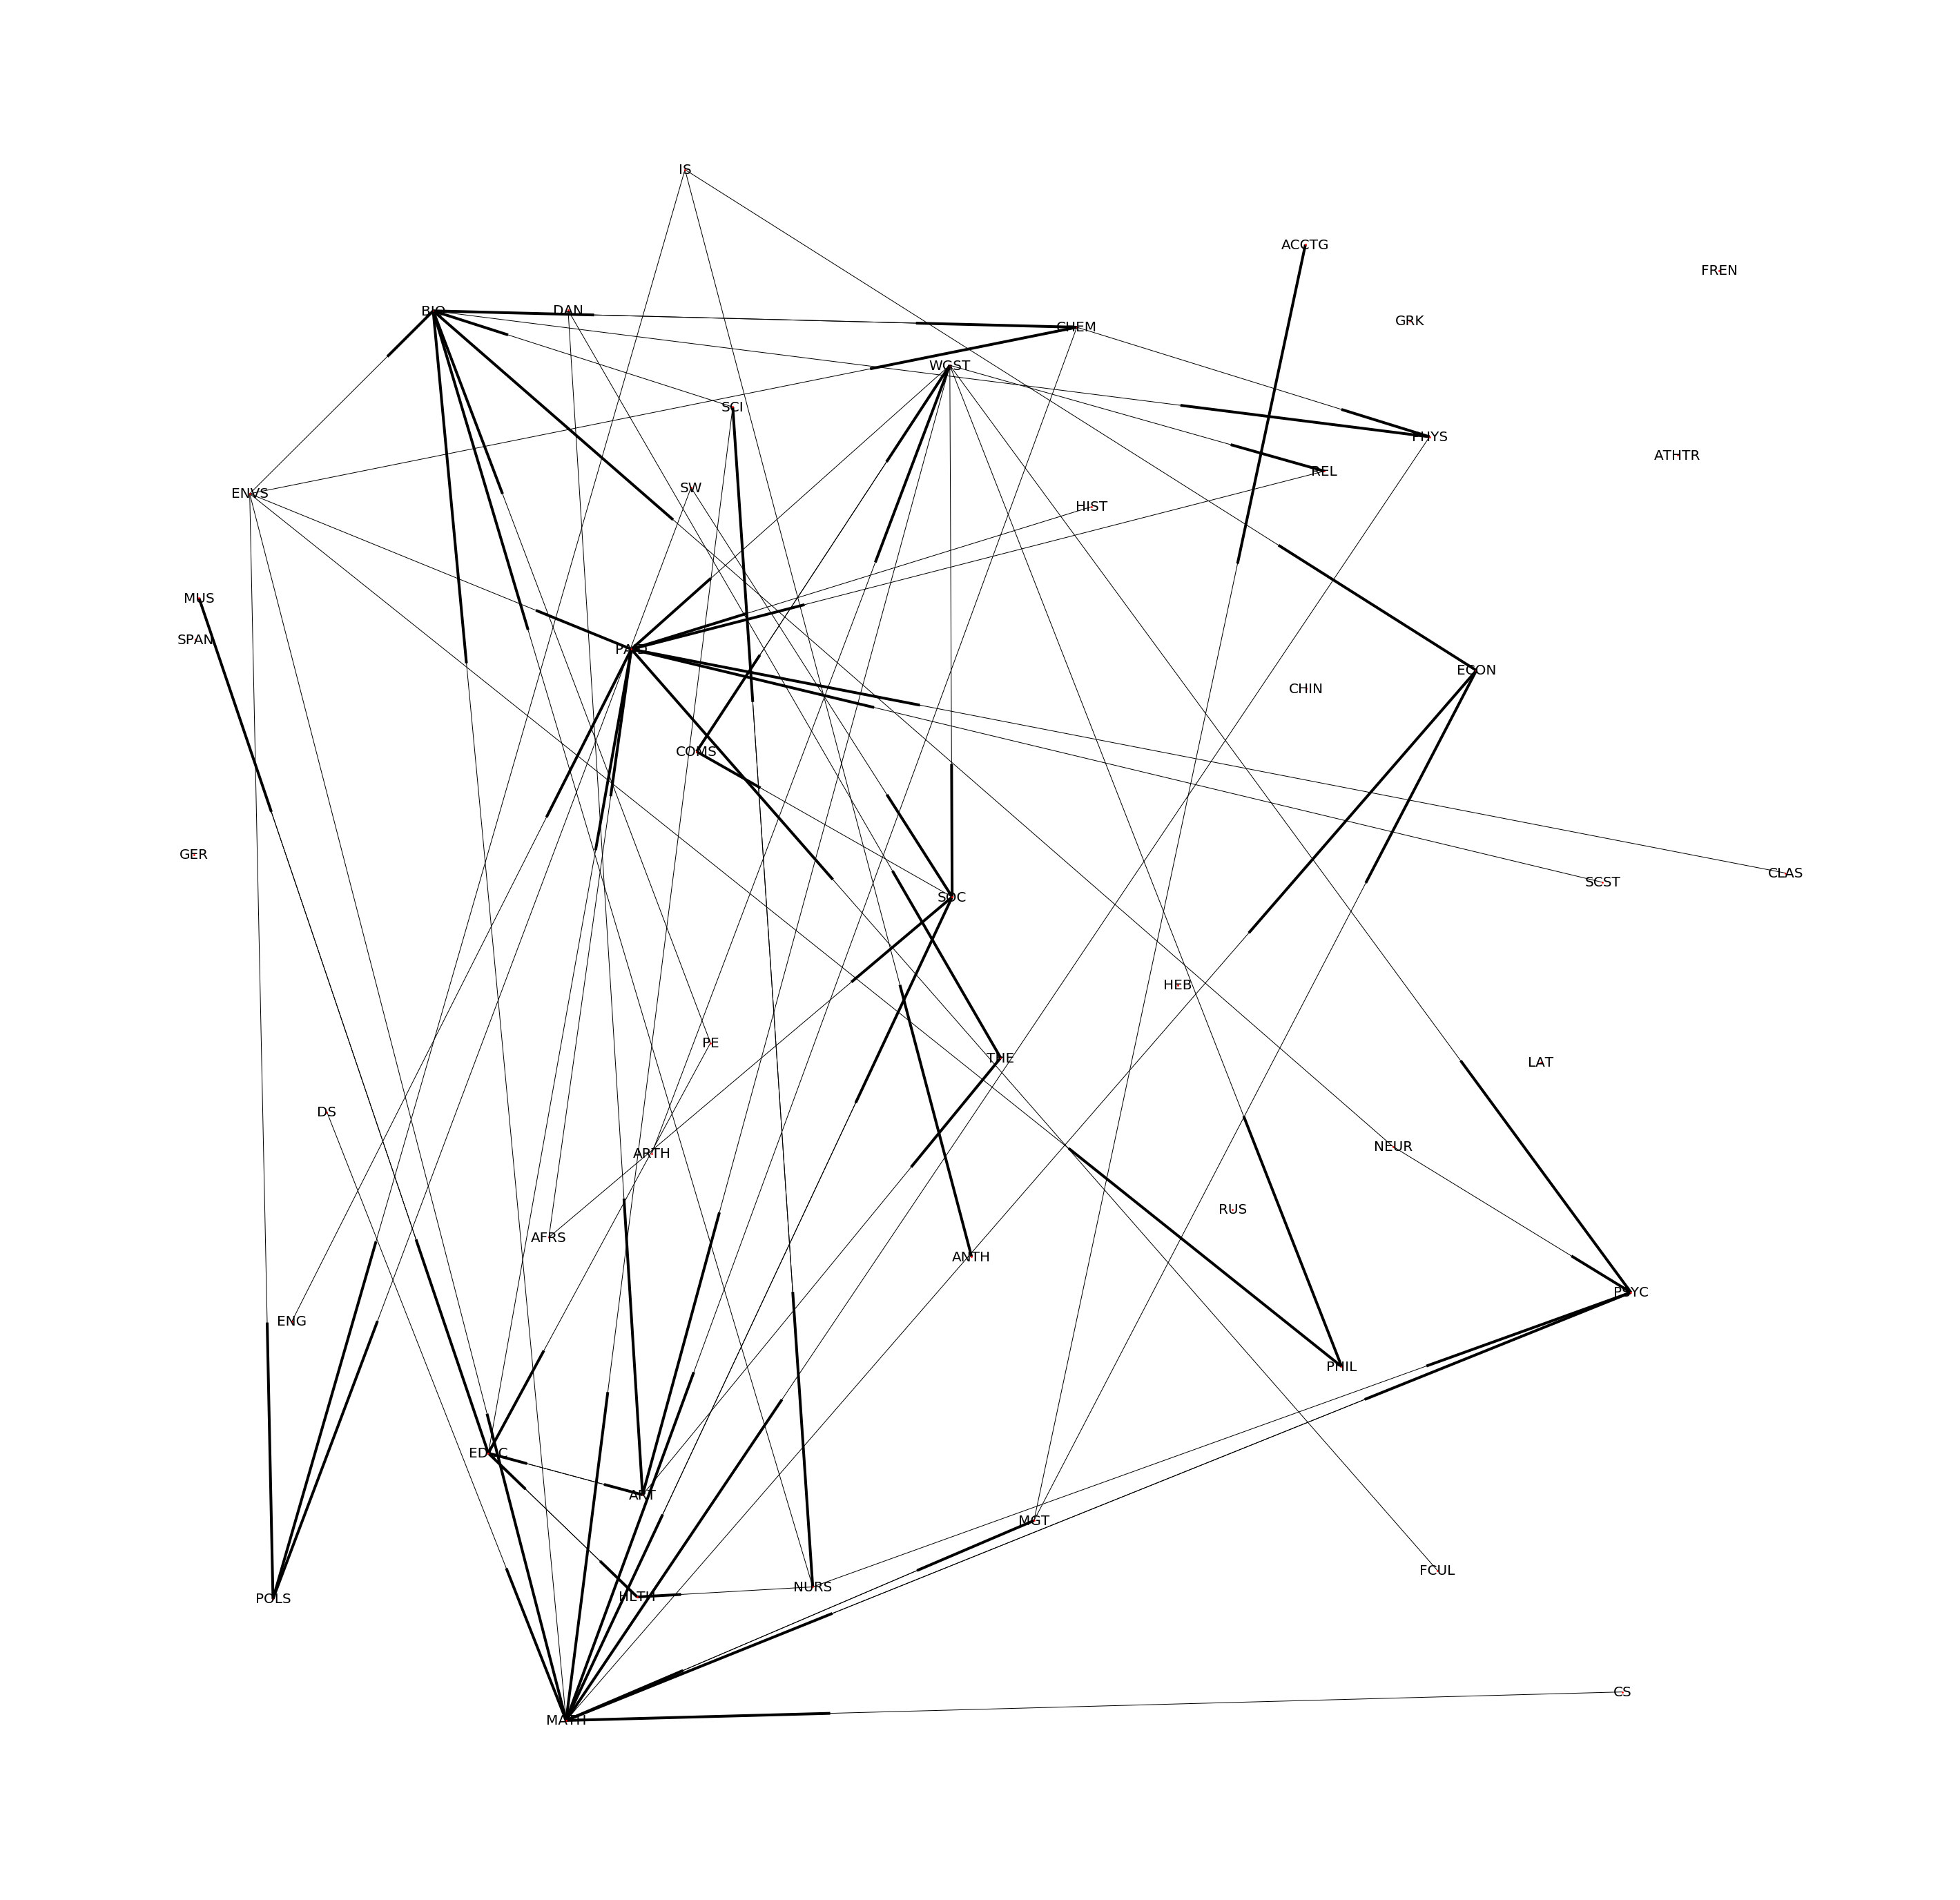

In [330]:
graf2fig, gax = plt.subplots(figsize = (50,50))
nx.draw(graf2,nx.spring_layout(graf2, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 20, node_size = 5)

In [250]:
new_df.groupby('relations')['abbv'].count().head()

relations
ART     1
COMS    1
PAID    1
PHIL    1
PSYC    1
Name: abbv, dtype: int64

In [251]:
new_df.groupby('relations')['abbv'].count().head(15) > 10

relations
ART     False
COMS    False
PAID    False
PHIL    False
PSYC    False
REL     False
SOC     False
WGST    False
Name: abbv, dtype: bool